In [ ]:
#ส่วนนี้จะเป็นส่วนการ import library ที่ใช้
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
#ส่วนนี้จะเป็น การสร้าง pathไปยังไฟล์ที่ชุดข้อมูล
datasetUrl = "/content/drive/MyDrive/Project/Dataset_leaf"
dataPath = pathlib.Path(datasetUrl)

In [ ]:
#ส่วนนี้จะนับภาพที่พบในนามสกุล jpg จะเห็นว่าในไดร์ฟที่เชื่อมมี 400 ภาพ.
imgCount = len(list(dataPath.glob('*/*.jpg')))
print(imgCount)

400


In [ ]:
#ส่วนนี้จะเป็นการสร้างตัวแปรกำหนดอัตราส่วนของภาพ
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
#ส่วนนี้จะเป็นการสร้างตัวแปรเก็บค่าใช้สร้างเทรนโมเดลโดยการแบ่งข้อมูล 2 อย่าง train และ validation 
#ตัวแปรไว้ใช้เก็บข้อมูลในการเทรนประมาณ80%ของข้อมูล จะเห็นว่าพบ 400 ไฟล์ภาพ จาก 2 class แต่ใช้320ไฟล์ภาพ สำหรับการเทรน
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataPath,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 400 files belonging to 2 classes.
Using 320 files for training.


In [ ]:
#ตัวแปรไว้ใช้เก็บข้อมูลไว้ใช้ทดสอบประมาณ 20% ของข้อมูล
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataPath,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 400 files belonging to 2 classes.
Using 80 files for validation.


In [ ]:
#ส่วนนี้จะเป็นการแสดงชื่อคลาสที่มี จะเห็นว่ามีด้วยกัน 2 class คือ Dicotyledon และ Monocotyledon
classNames = train_ds.class_names
print(classNames)

['Dicotyledon', 'Monocotyledon']


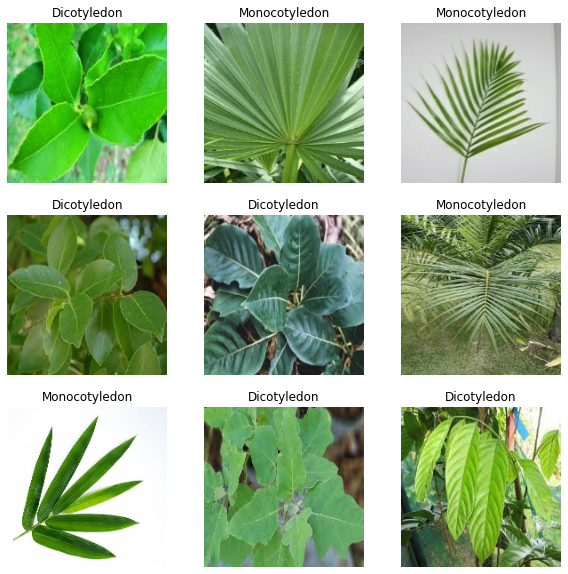

In [ ]:
#ส่วนนี้จะเป็นการพลอตรูปออกมาแสดงตัวอย่างของรูปภาพที่อยู่ใน class
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classNames[labels[i]])
    plt.axis("off")

In [ ]:
#ส่วนนี้จะเป็นแสดงรูปร่างของรูปภาพ
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
#ส่วนนี้จะเป็นจัดการการเทรนเป็นอัตโนมัติ
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#ส่วนนี้จะเป็นการปรับขนาดและค่าของภาพ
normalization_layer = layers.Rescaling(1./255)

In [ ]:
#ส่วนนี้จะเป็นการ Transform data
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
#ส่วนนี้จะเป็นการสร้างโมเดล
num_classes = len(classNames)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
#ส่วนนี้จะเป็นกำหนดค่ากระบวนการเรียนรู้
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#ส่วนนี้จะเป็นการแสดง Layer ทั้งหมดของ model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
#ส่วนนี้จะเป็นการ Train model
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
10/10 [==============================] - 15s 1s/step - loss: 0.8771 - accuracy: 0.4875 - val_loss: 0.6900 - val_accuracy: 0.5125
Epoch 2/20
10/10 [==============================] - 10s 1s/step - loss: 0.6876 - accuracy: 0.5094 - val_loss: 0.6776 - val_accuracy: 0.5625
Epoch 3/20
10/10 [==============================] - 10s 1s/step - loss: 0.6581 - accuracy: 0.6219 - val_loss: 0.6332 - val_accuracy: 0.6875
Epoch 4/20
10/10 [==============================] - 10s 1s/step - loss: 0.5977 - accuracy: 0.7000 - val_loss: 0.5925 - val_accuracy: 0.6375
Epoch 5/20
10/10 [==============================] - 10s 1s/step - loss: 0.5101 - accuracy: 0.7906 - val_loss: 0.6157 - val_accuracy: 0.7000
Epoch 6/20
10/10 [==============================] - 11s 1s/step - loss: 0.4384 - accuracy: 0.7781 - val_loss: 0.5712 - val_accuracy: 0.7125
Epoch 7/20
10/10 [==============================] - 10s 1s/step - loss: 0.3467 - accuracy: 0.8531 - val_loss: 0.6762 - val_accuracy: 0.6875
Epoch 8/20
10/10 [==

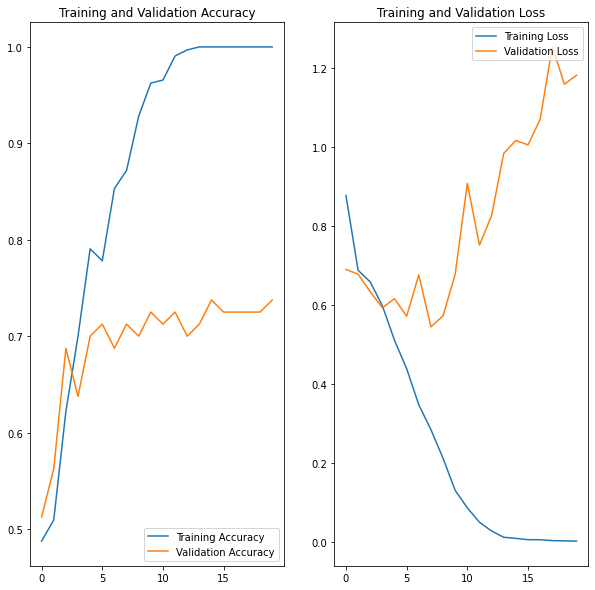

In [ ]:
#ส่วนนี้จะเป็นการสร้างกราฟ 2 กราฟ คือกราฟ data loss and values. และกราฟแสดง accuracy 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#ส่วนนี้เป็นการทดสอบภาพกับmodel ที่สร้าง
leaf_picture = "/content/drive/MyDrive/Test_leaf"
leafpicture_path = tf.keras.utils.get_file('/content/drive/MyDrive/Project/Test_leaf/1.jpg', origin=leaf_picture)

img = tf.keras.utils.load_img(
   leafpicture_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

prediction = model.predict(img_array)
score = tf.nn.softmax(prediction[0])
if(classNames[np.argmax(score)]=='Monocotyledon'):
    print(
    "ภาพนี้น่าจะเป็นของภาพพืชในประเภทใบเลี้ยงเดี่ยว({}), ที่ค่าความเชื่อมัน {:.2f} เปอร์เซ็นต์."
    .format(classNames[np.argmax(score)], 100 * np.max(score))
)
else: print(
    "ภาพนี้น่าจะเป็นของภาพพืชในประเภทใบเลี้ยงคู่({}), ที่ค่าความเชื่อมัน {:.2f} เปอร์เซ็นต์."
    .format(classNames[np.argmax(score)], 100 * np.max(score))
)    

ภาพนี้น่าจะเป็นของภาพพืชในประเภทใบเลี้ยงคู่(Dicotyledon), ที่ค่าความเชื่อมัน 99.76 เปอร์เซ็นต์.


In [ ]:
#ส่วนนี้จะเป็นการสร้างmodel
model.save('Prediction-of-Monocots-and-Dicotyledon.h5')